In [31]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles, make_blobs, make_moons
from sklearn.model_selection import train_test_split

torch.cuda.is_available(), torch.backends.mps.is_available()

(False, False)

In [2]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [3]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=99)
X, y

(array([[ 0.14424115, -0.80407463],
        [ 0.81931171, -0.17417491],
        [ 0.24547016,  0.97564023],
        ...,
        [-0.68838589,  0.69709548],
        [ 0.98949895,  0.47835664],
        [-0.08791009,  0.8001189 ]]),
 array([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 

In [4]:
circles = pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1], 'label': y})
circles.head()

,x1,x2,label
0,0.144241,-0.804075,1
1,0.819312,-0.174175,1
2,0.245470,0.975640,0
3,0.187504,0.834055,1
4,0.145504,0.996502,0


In [5]:
circles.value_counts()

x1         x2         label
-1.058619   0.008918  0        1
 0.454331   0.897540  0        1
 0.427424  -0.720102  1        1
 0.434203   0.904121  0        1
 0.434875  -0.701020  1        1
                              ..
-0.429401   0.712630  1        1
-0.428742  -0.689519  1        1
-0.424078   0.976621  0        1
-0.421251   0.958745  0        1
 1.079016   0.044245  0        1
Name: count, Length: 1000, dtype: int64

In [6]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

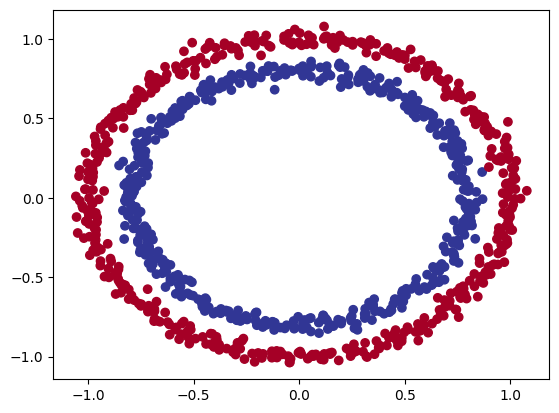

In [7]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.1442, -0.8041],
         [ 0.8193, -0.1742],
         [ 0.2455,  0.9756],
         [ 0.1875,  0.8341],
         [ 0.1455,  0.9965]]),
 tensor([1., 1., 0., 1., 0.]))

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=99)
len(X_train), len(X_test), len(Y_train), len(Y_test)

(800, 200, 800, 200)

In [10]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [11]:
circle_model = CircleModel()
circle_model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
untrained_prediction = circle_model(X_test)
untrained_prediction[:10]

tensor([[ 0.0997],
        [ 0.4747],
        [ 0.4542],
        [-0.2790],
        [ 0.3598],
        [-0.0654],
        [-0.1991],
        [-0.2716],
        [ 0.3336],
        [-0.2019]], grad_fn=<SliceBackward0>)

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=circle_model.parameters(), lr=0.1)

In [76]:
def accuracy_fn(y, y_pred):
    correct = torch.eq(y, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### Raw Binary Classification

In [15]:
y_probabilities = torch.sigmoid(untrained_prediction)
y_probabilities[:5]

tensor([[0.5249],
        [0.6165],
        [0.6116],
        [0.4307],
        [0.5890]], grad_fn=<SliceBackward0>)

In [16]:
y_pred = torch.round(y_probabilities)
y_pred[:5]

tensor([[1.],
        [1.],
        [1.],
        [0.],
        [1.]], grad_fn=<SliceBackward0>)

## Model Training

In [17]:
epochs = 100
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    circle_model.train()
    y_logits = circle_model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = criterion(y_logits, Y_train)
    acc = accuracy_fn(y=Y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    circle_model.eval()

    with torch.inference_mode():
        test_logits = circle_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = criterion(test_logits, Y_test)
        test_acc = accuracy_fn(y=Y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        train_losses.append(loss)
        test_losses.append(test_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69876, Accuracy: 51.50% | Test loss: 0.71792, Test acc: 47.00%
Epoch: 10 | Loss: 0.69718, Accuracy: 52.12% | Test loss: 0.71653, Test acc: 48.00%
Epoch: 20 | Loss: 0.69614, Accuracy: 52.12% | Test loss: 0.71513, Test acc: 48.50%
Epoch: 30 | Loss: 0.69538, Accuracy: 52.25% | Test loss: 0.71375, Test acc: 49.00%
Epoch: 40 | Loss: 0.69479, Accuracy: 52.25% | Test loss: 0.71244, Test acc: 48.50%
Epoch: 50 | Loss: 0.69433, Accuracy: 52.12% | Test loss: 0.71124, Test acc: 48.00%
Epoch: 60 | Loss: 0.69396, Accuracy: 52.38% | Test loss: 0.71015, Test acc: 47.50%
Epoch: 70 | Loss: 0.69365, Accuracy: 52.50% | Test loss: 0.70917, Test acc: 48.50%
Epoch: 80 | Loss: 0.69341, Accuracy: 52.62% | Test loss: 0.70830, Test acc: 49.50%
Epoch: 90 | Loss: 0.69321, Accuracy: 52.88% | Test loss: 0.70753, Test acc: 48.50%


## Optimization

- Training for longer
- Adding extra layer
- Adding more hidden units

In [18]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [19]:
model = CircleModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

epochs = 1000
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = criterion(y_logits, Y_train)
    acc = accuracy_fn(y=Y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = criterion(test_logits, Y_test)
        test_acc = accuracy_fn(y=Y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        train_losses.append(loss)
        test_losses.append(test_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.76458, Accuracy: 48.38% | Test loss: 0.70157, Test acc: 56.50%
Epoch: 100 | Loss: 0.69274, Accuracy: 53.25% | Test loss: 0.70181, Test acc: 47.50%
Epoch: 200 | Loss: 0.69251, Accuracy: 54.00% | Test loss: 0.70170, Test acc: 48.50%
Epoch: 300 | Loss: 0.69241, Accuracy: 55.00% | Test loss: 0.70152, Test acc: 48.50%
Epoch: 400 | Loss: 0.69235, Accuracy: 56.38% | Test loss: 0.70139, Test acc: 48.00%
Epoch: 500 | Loss: 0.69233, Accuracy: 57.38% | Test loss: 0.70129, Test acc: 50.00%
Epoch: 600 | Loss: 0.69231, Accuracy: 58.88% | Test loss: 0.70122, Test acc: 49.50%
Epoch: 700 | Loss: 0.69231, Accuracy: 59.75% | Test loss: 0.70118, Test acc: 50.00%
Epoch: 800 | Loss: 0.69230, Accuracy: 59.88% | Test loss: 0.70114, Test acc: 51.00%
Epoch: 900 | Loss: 0.69230, Accuracy: 60.62% | Test loss: 0.70112, Test acc: 51.50%


In [20]:
model = CircleModel()
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

epochs = 1000
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = criterion(y_logits, Y_train)
    acc = accuracy_fn(y=Y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = criterion(test_logits, Y_test)
        test_acc = accuracy_fn(y=Y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        train_losses.append(loss)
        test_losses.append(test_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.53366, Accuracy: 52.62% | Test loss: 0.46257, Test acc: 43.50%
Epoch: 100 | Loss: 0.48608, Accuracy: 51.62% | Test loss: 0.55825, Test acc: 43.50%
Epoch: 200 | Loss: 0.48481, Accuracy: 51.62% | Test loss: 0.56292, Test acc: 43.50%
Epoch: 300 | Loss: 0.48433, Accuracy: 51.62% | Test loss: 0.56476, Test acc: 43.50%
Epoch: 400 | Loss: 0.48893, Accuracy: 51.62% | Test loss: 0.54599, Test acc: 43.50%
Epoch: 500 | Loss: 0.48571, Accuracy: 51.62% | Test loss: 0.55900, Test acc: 43.50%
Epoch: 600 | Loss: 0.48617, Accuracy: 51.62% | Test loss: 0.55710, Test acc: 43.50%
Epoch: 700 | Loss: 0.48673, Accuracy: 51.62% | Test loss: 0.55473, Test acc: 43.50%
Epoch: 800 | Loss: 0.48772, Accuracy: 51.62% | Test loss: 0.55068, Test acc: 43.50%
Epoch: 900 | Loss: 0.48657, Accuracy: 51.62% | Test loss: 0.55530, Test acc: 43.50%


## Non-Linearity

Adding an activation function

In [21]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(
            self.relu(self.layer_2(
                self.relu(self.layer_1(x))
            ))
        )

In [22]:
model = CircleModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

epochs = 1000
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = criterion(y_logits, Y_train)
    acc = accuracy_fn(y=Y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = criterion(test_logits, Y_test)
        test_acc = accuracy_fn(y=Y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        train_losses.append(loss)
        test_losses.append(test_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69378, Accuracy: 50.38% | Test loss: 0.69526, Test acc: 44.00%
Epoch: 100 | Loss: 0.69196, Accuracy: 58.50% | Test loss: 0.70030, Test acc: 49.50%
Epoch: 200 | Loss: 0.69143, Accuracy: 56.38% | Test loss: 0.69997, Test acc: 47.50%
Epoch: 300 | Loss: 0.69083, Accuracy: 55.00% | Test loss: 0.69961, Test acc: 45.00%
Epoch: 400 | Loss: 0.69016, Accuracy: 54.62% | Test loss: 0.69931, Test acc: 44.50%
Epoch: 500 | Loss: 0.68938, Accuracy: 55.12% | Test loss: 0.69881, Test acc: 46.50%
Epoch: 600 | Loss: 0.68839, Accuracy: 57.38% | Test loss: 0.69824, Test acc: 50.50%
Epoch: 700 | Loss: 0.68709, Accuracy: 64.62% | Test loss: 0.69756, Test acc: 57.00%
Epoch: 800 | Loss: 0.68530, Accuracy: 68.75% | Test loss: 0.69650, Test acc: 63.50%
Epoch: 900 | Loss: 0.68286, Accuracy: 68.62% | Test loss: 0.69494, Test acc: 59.00%


## Replicating non-linearity

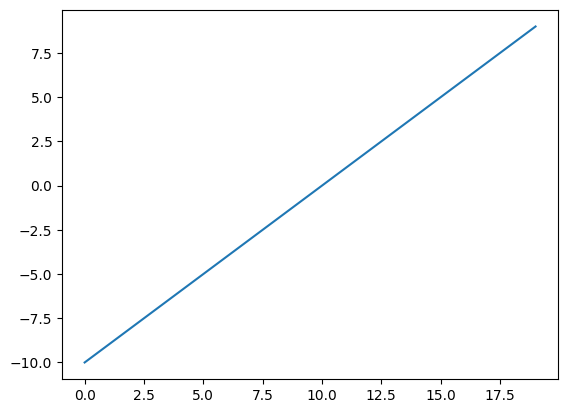

In [23]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
plt.plot(A)

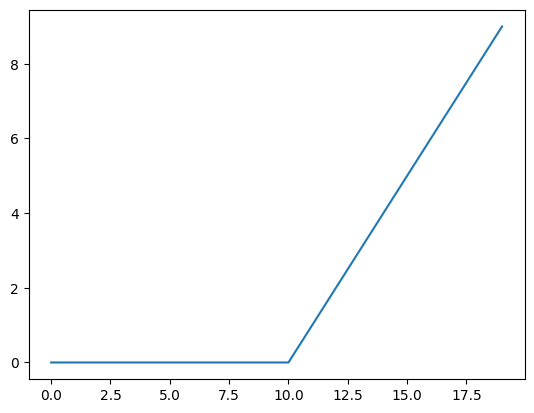

In [24]:
def relu(x):
  return torch.maximum(torch.tensor(0), x)

relu_A = relu(A)
plt.plot(relu_A)

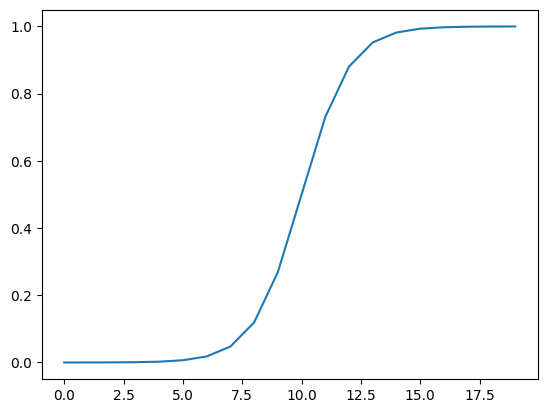

In [25]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

sigmoid_A = sigmoid(A)
plt.plot(sigmoid_A)

## Multi-class Classification Problem

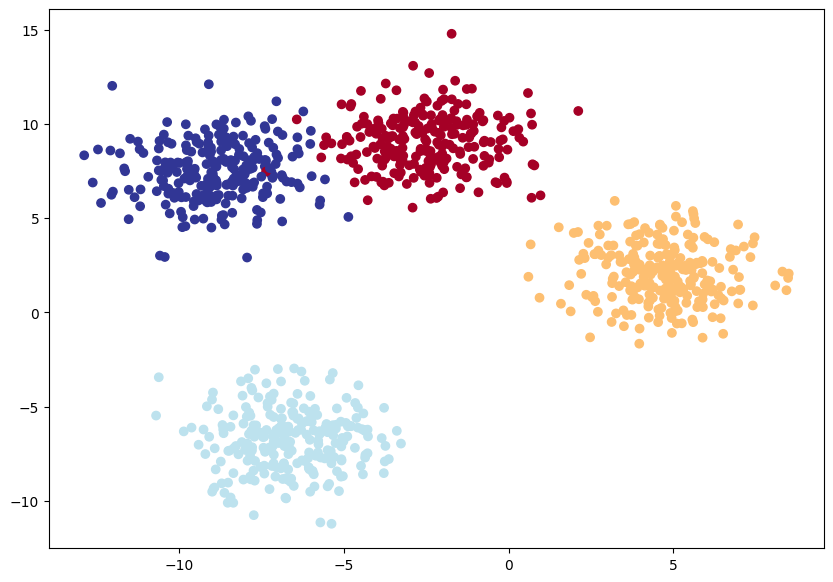

In [26]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [27]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer(x)

In [28]:
blob_model = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES
)

blob_model

BlobModel(
  (linear_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=blob_model.parameters(), lr=0.1)

epochs = 100

for epoch in range(epochs):
    blob_model.train()
    y_logits = blob_model(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = criterion(y_logits, y_blob_train)
    acc = accuracy_fn(y=y_blob_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    blob_model.eval()

    with torch.inference_mode():
        y_test_logits = blob_model(X_blob_test)
        y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
        test_loss = criterion(y_test_logits, y_blob_test)
        test_acc = accuracy_fn(y=y_blob_test, y_pred=y_test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.74824, Acc: 0.00% | Test Loss: 0.92273, Test Acc: 51.00%
Epoch: 10 | Loss: 0.26868, Acc: 98.75% | Test Loss: 0.23318, Test Acc: 99.00%
Epoch: 20 | Loss: 0.11153, Acc: 99.00% | Test Loss: 0.10102, Test Acc: 99.50%
Epoch: 30 | Loss: 0.07247, Acc: 99.12% | Test Loss: 0.06432, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05636, Acc: 99.12% | Test Loss: 0.04846, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04786, Acc: 99.12% | Test Loss: 0.03986, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04269, Acc: 99.12% | Test Loss: 0.03453, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03925, Acc: 99.12% | Test Loss: 0.03091, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03682, Acc: 99.12% | Test Loss: 0.02830, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03502, Acc: 99.12% | Test Loss: 0.02634, Test Acc: 99.50%


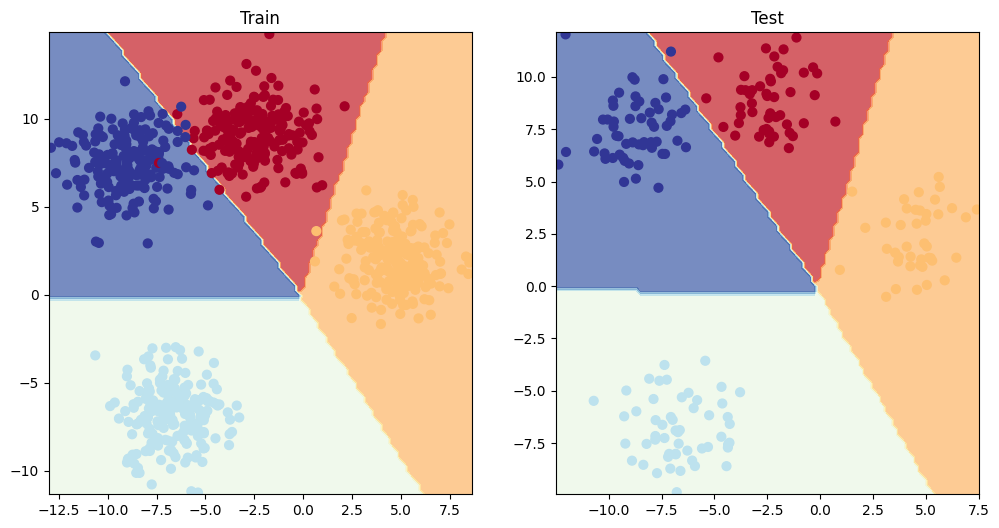

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(blob_model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(blob_model, X_blob_test, y_blob_test)

## Exercise

Make a binary classification dataset with Scikit-Learn's make_moons() function.
For consistency, the dataset should have 1000 samples and a random_state=42.

In [87]:
RANDOM_SEED = 42

X_moon, y_moon = make_moons(
    n_samples=1000,
    random_state=RANDOM_SEED
)

In [44]:
X_moon.shape, X_moon

((1000, 2),
 array([[ 0.00872719,  0.36817352],
        [ 0.921384  , -0.49690497],
        [ 0.94022577, -0.49821192],
        ...,
        [ 1.64091013, -0.26761592],
        [-0.91991616,  0.39211512],
        [ 0.80079841,  0.59893397]]))

In [45]:
y_moon.shape, y_moon

((1000,),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 1,

Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [88]:
X_moon = torch.from_numpy(X_moon).type(torch.float)
y_moon = torch.from_numpy(y_moon).type(torch.float)

X_train_moon, X_test_moon, y_train_moon, y_test_moon = train_test_split(X_moon, y_moon, test_size=0.2)
print(f"Train/Test lengths: {len(X_train_moon), len(X_test_moon), len(y_train_moon), len(y_test_moon)}")
print(f"X_train_moon dtype: {X_train_moon.dtype}, y_train_moon dtype: {y_train_moon.dtype}")

Train/Test lengths: (800, 200, 800, 200)
X_train_moon dtype: torch.float32, y_train_moon dtype: torch.float32


Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

Feel free to use any combination of PyTorch layers (linear and non-linear) you want

In [93]:
class MoonModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.sequence = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )

    def forward(self, x):
        return self.sequence(x)

In [97]:
moon = MoonModel(input_features=2, output_features=1)
moon

MoonModel(
  (sequence): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

Setup a binary classification compatible loss function and optimizer to use when training the model

In [98]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=moon.parameters(), lr=0.1)

Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
- To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.
- Train the model for long enough for it to reach over 96% accuracy.
- The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy

In [99]:
epochs = 1000

for epoch in range(epochs):
    moon.train()
    y_logits = moon(X_train_moon).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = criterion(y_logits, y_train_moon)
    acc = accuracy_fn(y=y_train_moon, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    moon.eval()

    with torch.inference_mode():
        test_logits = moon(X_test_moon).squeeze()
        test_y_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = criterion(test_logits, y_test_moon)
        test_acc = accuracy_fn(y=y_test_moon, y_pred=test_y_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69724, Acc: 50.25% | Test Loss: 0.69974, Test Acc: 49.00%
Epoch: 10 | Loss: 0.69254, Acc: 50.25% | Test Loss: 0.69424, Test Acc: 49.00%
Epoch: 20 | Loss: 0.68851, Acc: 50.25% | Test Loss: 0.68947, Test Acc: 49.00%
Epoch: 30 | Loss: 0.68482, Acc: 50.25% | Test Loss: 0.68504, Test Acc: 49.00%
Epoch: 40 | Loss: 0.68081, Acc: 50.25% | Test Loss: 0.68025, Test Acc: 49.00%
Epoch: 50 | Loss: 0.67600, Acc: 68.25% | Test Loss: 0.67459, Test Acc: 72.50%
Epoch: 60 | Loss: 0.66956, Acc: 80.12% | Test Loss: 0.66722, Test Acc: 83.50%
Epoch: 70 | Loss: 0.65980, Acc: 80.12% | Test Loss: 0.65618, Test Acc: 82.00%
Epoch: 80 | Loss: 0.64580, Acc: 78.75% | Test Loss: 0.64053, Test Acc: 81.50%
Epoch: 90 | Loss: 0.62621, Acc: 79.38% | Test Loss: 0.61876, Test Acc: 81.50%
Epoch: 100 | Loss: 0.59921, Acc: 79.62% | Test Loss: 0.58904, Test Acc: 82.00%
Epoch: 110 | Loss: 0.56455, Acc: 79.62% | Test Loss: 0.55127, Test Acc: 82.50%
Epoch: 120 | Loss: 0.52311, Acc: 79.88% | Test Loss: 0.50667, T

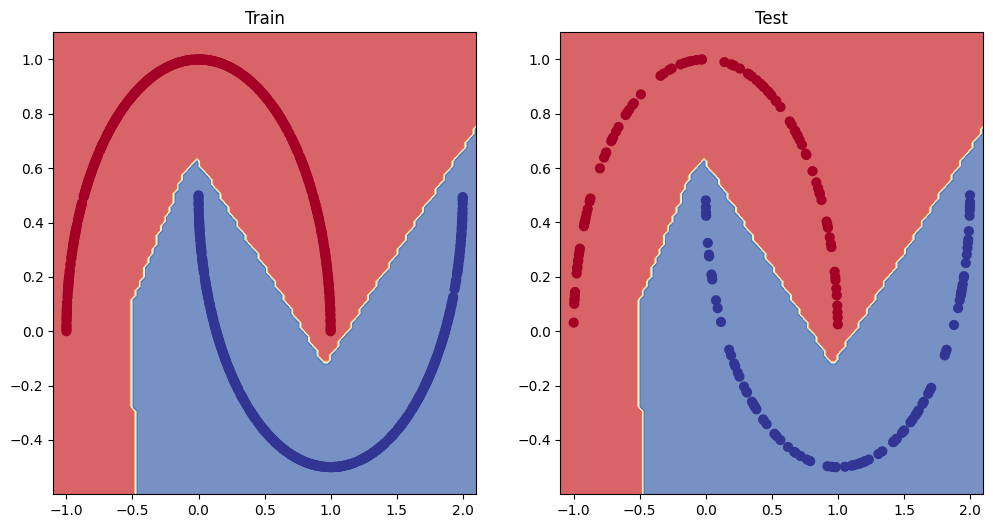

In [101]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(moon, X_train_moon, y_train_moon)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(moon, X_test_moon, y_test_moon)